In [ ]:

HOPFIELD NETWORK (HEBBIAN AND GRADIENT DESCENT TRAINING)

In [ ]:
LOAD OLIVETTI FACES

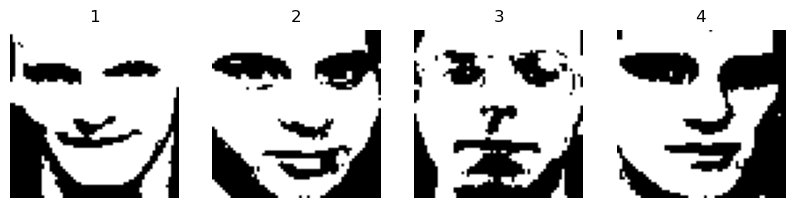

(4, 64, 64)

In [222]:

from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

num_img = 4
# Load Olivetti Faces dataset
data = fetch_olivetti_faces(shuffle=True)
images = data.images # [:num_img]  # Select the first num_img images

# extract num_img images at random 

indices = np.random.choice(images.shape[0], num_img, replace=False)  # Pick N random indices
images = images[indices]

# Normalize images to be in the range [-1, 1]
images = np.where(images >= 0.5, 1, -1)

# Plot the normalized images
fig, axes = plt.subplots(1, num_img, figsize=(10, 4))
for i in range(num_img):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"{i+1}")

plt.show()

images.shape

In [ ]:
Load MINST data 

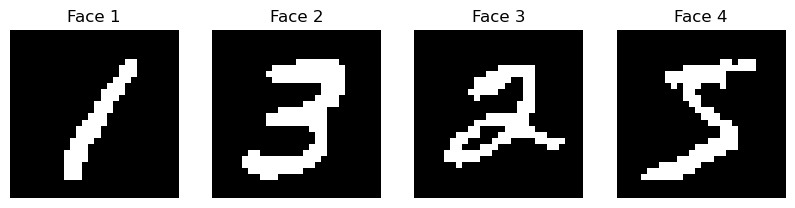

(4, 28, 28)

In [162]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

def load_mnist_digits(labels, num_samples=1):
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist.data.values, mnist.target.astype(int)
    img_size = int(np.sqrt(X.shape[1]))
    
    selected_images = []
    for label in labels:
        images = X[y == label][:num_samples]
        images = images.reshape(-1, img_size, img_size)
        images = np.where(images > 127, 1, -1)  # Binarize
        selected_images.append(images)
    
    return np.vstack(selected_images)

labels = [1, 3, 2, 5]
images = load_mnist_digits(labels)

# Plot the images
fig, axes = plt.subplots(1, len(labels), figsize=(10, 4))
for i in range(len(labels)):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Face {i+1}")

plt.show()

images.shape

In [ ]:
LOAD ART IMAGES 

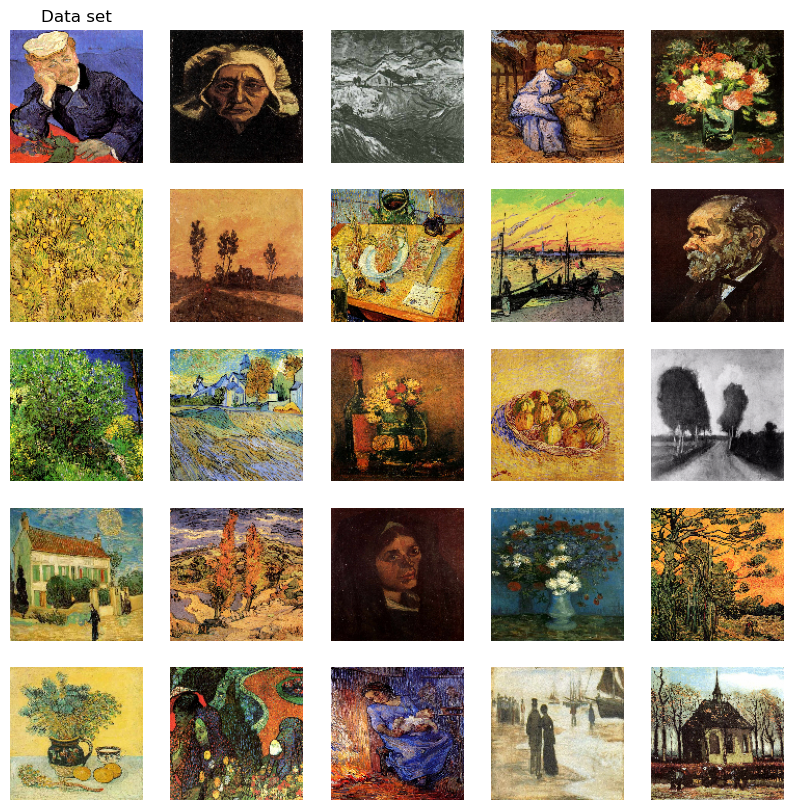

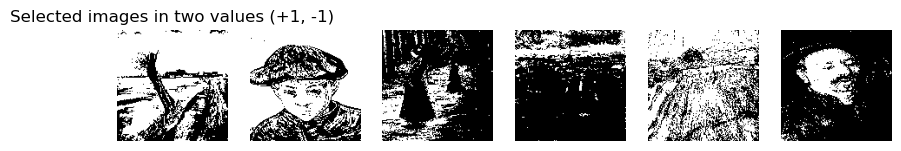

(6, 128, 128)

In [58]:
import numpy as np
import matplotlib.pyplot as plt

images = np.load("VanGogh.npy")

# Plot the images
Np = 5 
fig, axes = plt.subplots(Np, Np, figsize=(10, 10))
for i in range(Np):
    for j in range(Np):
        axes[i,j].imshow(images[(i-1)*Np+j],cmap='gray')
        axes[i,j].axis("off")
        
axes[0,0].set_title("Data set")
plt.show()

images.shape


# extract Ns images at random 

Ns=6
indices = np.random.choice(images.shape[0], Ns, replace=False)  # Pick N random indices
images = images[indices]

images = images[:,:,:,0]
# Normalize images to be in the range [-1, 1]
images = np.where(images >= 0.5, 1, -1)

# Plot the images
fig, axes = plt.subplots(1, Ns, figsize=(10, 10))
for i in range(Ns):
        axes[i].imshow(images[i],cmap='gray')
        axes[i].axis("off")

axes[0].set_title("Selected images in two values (+1, -1)")
plt.show()

images.shape


Epoch 30/30, Loss: 0 0  

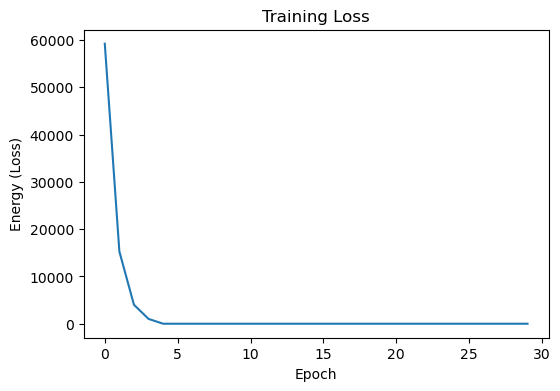

In [182]:
def train_hopfield(images, gamma=0.01, epochs=50, Method="LeastSquare", decay=0):
    """
    Train a Hopfield Network using Hebbian or Least Squares learning.

    Args:
        images (numpy.ndarray): Array of shape (P, H, W) where P is the number of images.
        gamma (float): Learning rate.
        epochs (int): Number of training iterations.
        Method (str): Training method, either "Hebbian" or "LeastSquare".
        decay (float): Weight decay factor.

    Returns:
        W (numpy.ndarray): Trained weight matrix.
        losses (list): Loss values per epoch.
    """
    losses = []
    P, img_size, _ = images.shape
    N = img_size * img_size
    W = np.zeros((N, N))

    images_flat = images.reshape(P, N)

    for epoch in range(epochs):
        loss = 0
        for x in images_flat:
            #y = np.sign(W @ x)  # Classification output
            #y[y == 0] = 1  # Avoid zero activation
            y = np.where(W @ x >= 0, 1, -1)  # Ensure binary activation (+1 or -1)
            misclassified = x * y < 0
            if np.any(misclassified):
                # Hebbian training
                if Method == "Hebbian":
                    loss += -np.sum(x * (W @ x))  # Compute energy (loss function)
                    W += gamma * np.outer(x, x) / N - decay * W  # Update rule with decay
                
                # Least Squares training
                elif Method == "LeastSquare":
                    error = x - y  # Compute error
                    loss += np.sum(error**2)  # Sum of squared errors (L2 loss)
                    W += gamma * np.outer(error, x) - decay * W  # Update with decay
                        
        losses.append(loss)
        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {loss}",end=" ")
        
    return W, losses

def recall(W, x, epochs=100):
    N = W.shape[0]
    x = x.flatten()
    for _ in range(epochs):
        x = np.sign(W @ x)
        x[x == 0] = 1
    return x.reshape(int(np.sqrt(N)), int(np.sqrt(N)))

def add_noise(image, noise_level=0.3):
    noisy_image = image.copy().flatten()
    num_noisy_pixels = int(noise_level * noisy_image.size)
    indices = np.random.choice(noisy_image.size, num_noisy_pixels, replace=False)
    noisy_image[indices] *= -1  # Flip pixel values
    return noisy_image.reshape(image.shape)


#Method = "Hebbian" use gradient descent algorithm based on energy E = - X*(W*X) 
#Method = "LeastSquare" use gradient descent algorithm based on energy E = 0.5 * (sgn(W*X) - Ydata)^2
#decay = if >0 shrink weight parameters (older patterns are forgotten), if <0 impose soft constraint of small W^2
W, losses = train_hopfield(images, gamma=0.01, epochs=30, Method="LeastSquare", decay=0)


np.fill_diagonal(W, 0)  # No self-connections
# Plot loss function
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Energy (Loss)")
plt.title("Training Loss")
plt.show()

In [ ]:
DIRECT HEBBIAN TRAINING (NO GRADIENT DESCENT) 

In [194]:
"""
Hebbian learning: W_ij = sum_p (x_i^p * x_j^p)/N

N number of patterns
"""

P, img_size, _ = images.shape
N = img_size * img_size
W = np.zeros((N, N))

images_flat = images.reshape(P, N)

for x in images_flat:
    W += np.outer(x, x)/ N 
    

#Parisi_threshold = 10
# Hebbian learning: W_ij = sum_p (x_i^p * x_j^p)/N
#for x in images_flat:
#    update = np.outer(x, x)/ N 
#    # Apply correction: Ignore update if abs(W_ij) does not exceed 0.4
#    W_new = W + update
#    W = np.where(np.abs(W_new) > Parisi_threshold, W, W_new)  # Parisi correction to improve storage/reduce confusion


In [ ]:
PLOT ORIGINAL, NOISY AND RECALLED PATTERNS

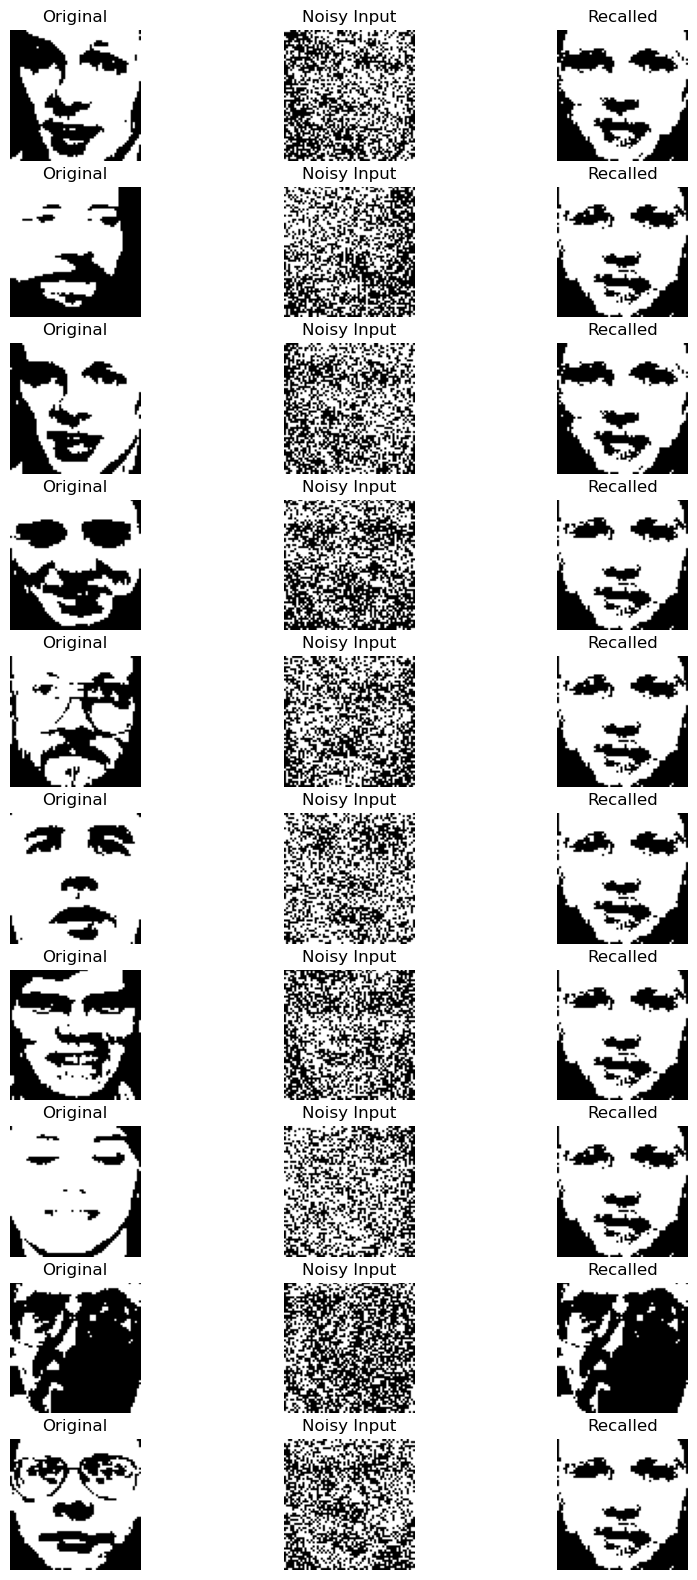

In [212]:
# Test with noisy images
P, img_size, _ = images.shape
originals = images
noisies = [add_noise(img, noise_level=0.35) for img in originals]
recalleds = [recall(W, img) for img in noisies]

#P = 5
# Plot results
fig, axes = plt.subplots(P, 3, figsize=(10,2*P))
for i in range(P):
    axes[i, 0].imshow(originals[i], cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(noisies[i], cmap='gray')
    axes[i, 1].set_title("Noisy Input")
    axes[i, 2].imshow(recalleds[i], cmap='gray')
    axes[i, 2].set_title("Recalled")
    for j in range(3):
        axes[i, j].axis("off")
plt.show()


In [ ]:
PLOT 5 COLUMNS OF THE TRAINED SYMMETRIC WEIGHT MATRIX AS IMAGES 

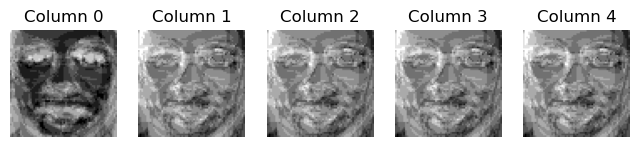

In [214]:
# Plot the first five columns of the weight matrix as images
Ncolumns = 5 
fig, axes = plt.subplots(1, Ncolumns, figsize=(8, 8))
img_size = int(np.sqrt(W.shape[0]))  # Assuming square images

for i in range(Ncolumns):
    column_image = W[:, i].reshape(img_size, img_size)  # Reshape to image size
    axes[i].imshow(column_image, cmap='gray')
    axes[i].set_title(f"Column {i}")
    axes[i].axis("off")

plt.show()


In [ ]:
PLOT 5x5 COLUMNS OF THE TRAINED SYMMETRIC WEIGHT MATRIX AS IMAGES 

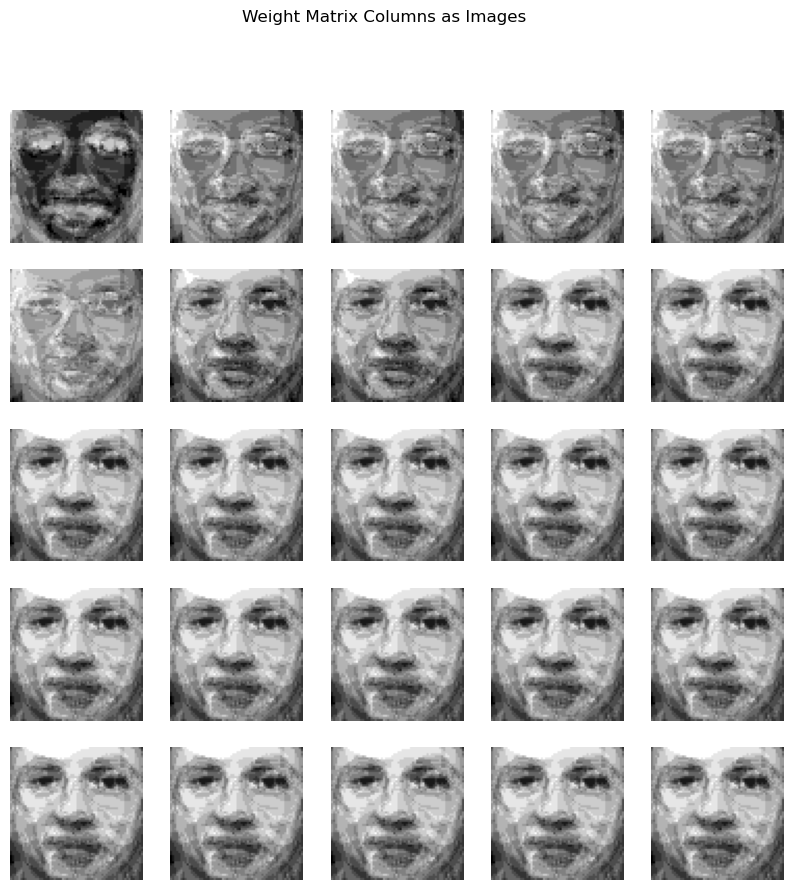

In [216]:
# Plot 5x5 grid of the weight matrix columns as images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
img_size = int(np.sqrt(W.shape[0]))  # Assuming square images

for i in range(5):
    for j in range(5):
        column_index = i * 5 + j  # Compute column index
        if column_index < W.shape[1]:  # Ensure index is within bounds
            column_image = W[:, column_index].reshape(img_size, img_size)
            axes[i, j].imshow(column_image, cmap='gray')
            axes[i, j].axis("off")

plt.suptitle("Weight Matrix Columns as Images")
plt.show()



In [ ]:
PLOT WEIGHT MATRIX AS A NxN PATTERN

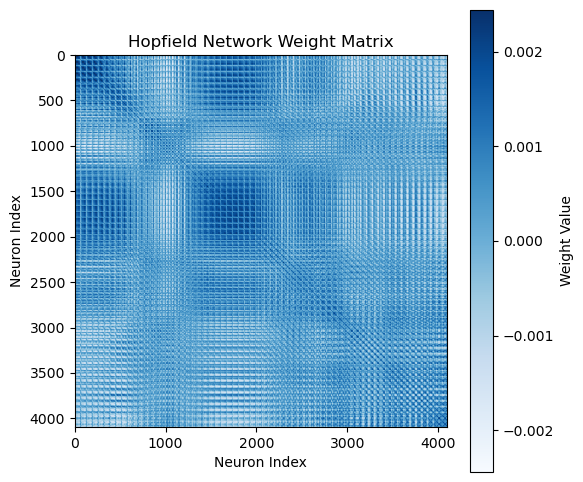

In [218]:


N = W.shape[0]
    
plt.figure(figsize=(6, 6))
plt.imshow(W, cmap="Blues")
plt.colorbar(label="Weight Value")  # Add a color bar
plt.title("Hopfield Network Weight Matrix")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.show()



In [ ]:
Generates Hopfield network samples using Gibbs-Metropolis sampling

Gibbs step 8000 

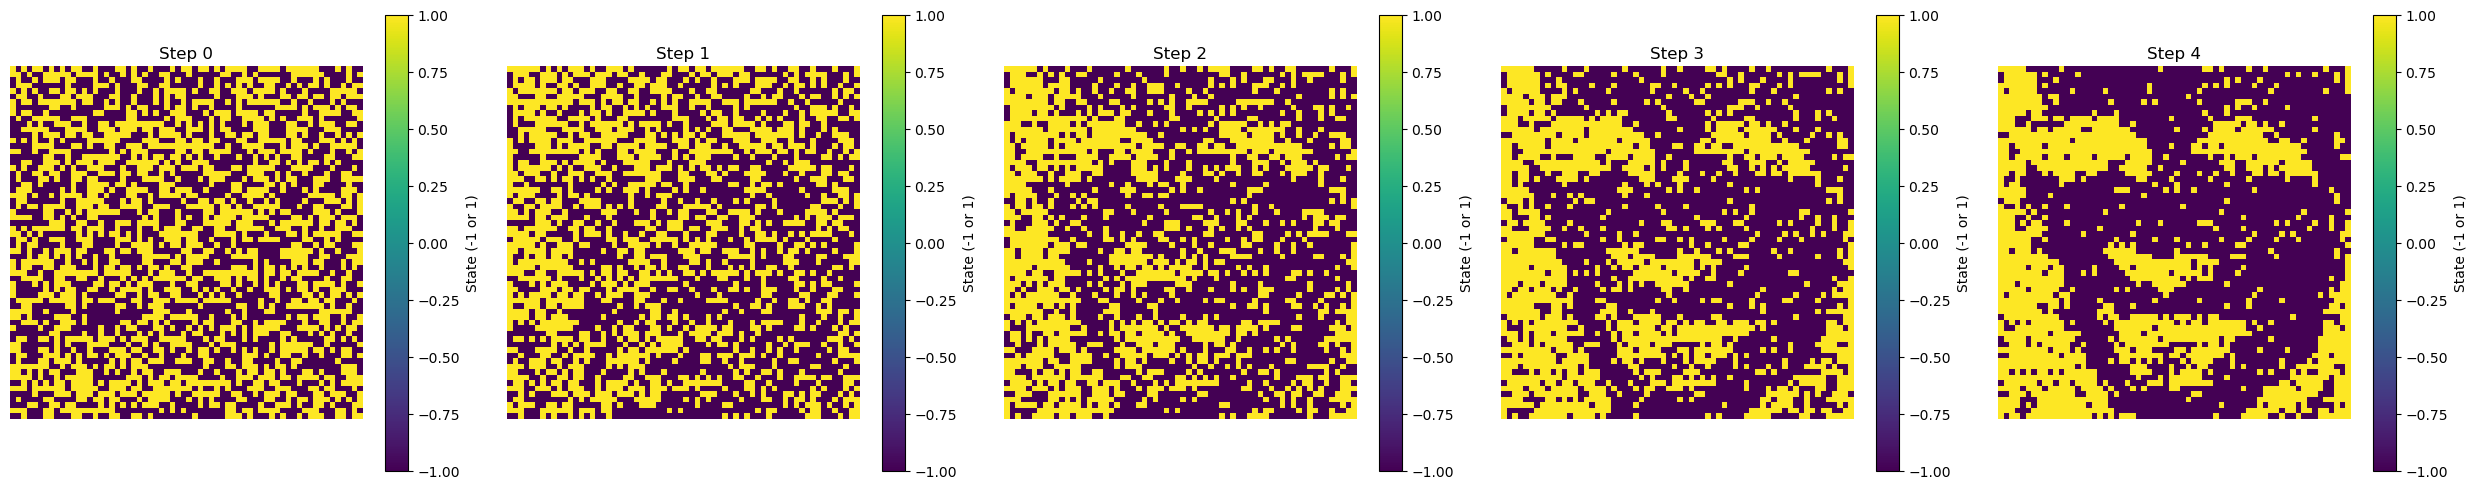

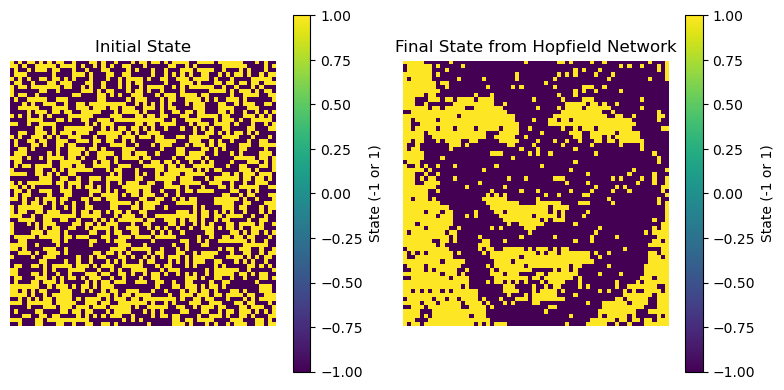

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def hopfield_energy(W, x):
    """Computes the energy of a given state x in the Hopfield network."""
    return -0.5 * x @ W @ x.T  # Energy function: E = -0.5 * sum_ij W_ij x_i x_j

def metropolis_step(W, x, beta=1.0):
    """
    Performs a single Metropolis update step.

    Parameters:
        W (numpy.ndarray): NxN weight matrix.
        x (numpy.ndarray): Current state vector of shape (N,).
        beta (float): Inverse temperature parameter (controls randomness).
    
    Returns:
        numpy.ndarray: Updated state vector.
    """
    N = len(x)
    i = np.random.randint(N)  # Pick a random neuron
    x_flip = x.copy()
    x_flip[i] *= -1  # Flip state of chosen neuron

    # Compute energy change
    dE = hopfield_energy(W, x_flip) - hopfield_energy(W, x)

    # Metropolis criterion: Accept with probability min(1, exp(-beta * dE))
   # if np.random.rand() < np.exp(-beta * dE):
    if np.random.rand() < np.exp(np.clip(-beta * dE, -100, 100)):

        return x_flip  # Accept new state
    return x  # Keep old state

def gibbs_metropolis(W, steps=1000, beta=1, save_interval=1000):
    """
    Generates Hopfield network samples using Gibbs-Metropolis sampling.

    Parameters:
        W (numpy.ndarray): NxN weight matrix.
        steps (int): Number of sampling steps.
        beta (float): Inverse temperature parameter.

    Returns:
        np.ndarray: Collected states over iterations.
    """
    N = W.shape[0]
    x_rand = np.random.choice([-1, 1], size=N)  # Random initial state
    samples = []
    x = 0*images_flat[0] + 1.0*x_rand # choose one of the trained patterns
    for i in range(steps):
        x = metropolis_step(W, x, beta) 
        if i % save_interval == 0:
            samples.append(x.copy())  # Append every `save_interval` steps
            print(f"\rGibbs step {i}",end=" ")
    return np.array(samples)
    

# Example usage
N = W.shape[0]  # Number of neurons

samples = gibbs_metropolis(W, steps=10000, beta=5,save_interval=2000)

num_plots = samples.shape[0] 
Nsteps = 1
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
for i, step in enumerate(range(0, len(samples), Nsteps)):
    axes[i].imshow(samples[step].reshape((img_size, img_size)))
    axes[i].set_title(f"Step {step}")
    axes[i].axis("off")
    fig.colorbar(axes[i].imshow(samples[step].reshape((img_size, img_size))), ax=axes[i], label="State (-1 or 1)")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(4 *2, 4))
# Visualizing initial state
img_size = int(np.sqrt(W.shape[0]))  # square image
axes[0].imshow(samples[0].reshape((img_size, img_size)))
axes[0].set_title(f"Initial State")
axes[0].axis("off")
fig.colorbar(axes[0].imshow(samples[0].reshape((img_size, img_size))), ax=axes[0], label="State (-1 or 1)")

# Visualizing last state
axes[1].imshow(samples[-1].reshape((img_size, img_size)))
axes[1].set_title(f"Final State from Hopfield Network")
axes[1].axis("off")
fig.colorbar(axes[1].imshow(samples[-1].reshape((img_size, img_size))), ax=axes[1], label="State (-1 or 1)")

plt.tight_layout()
plt.show()

In [71]:
samples.shape

()

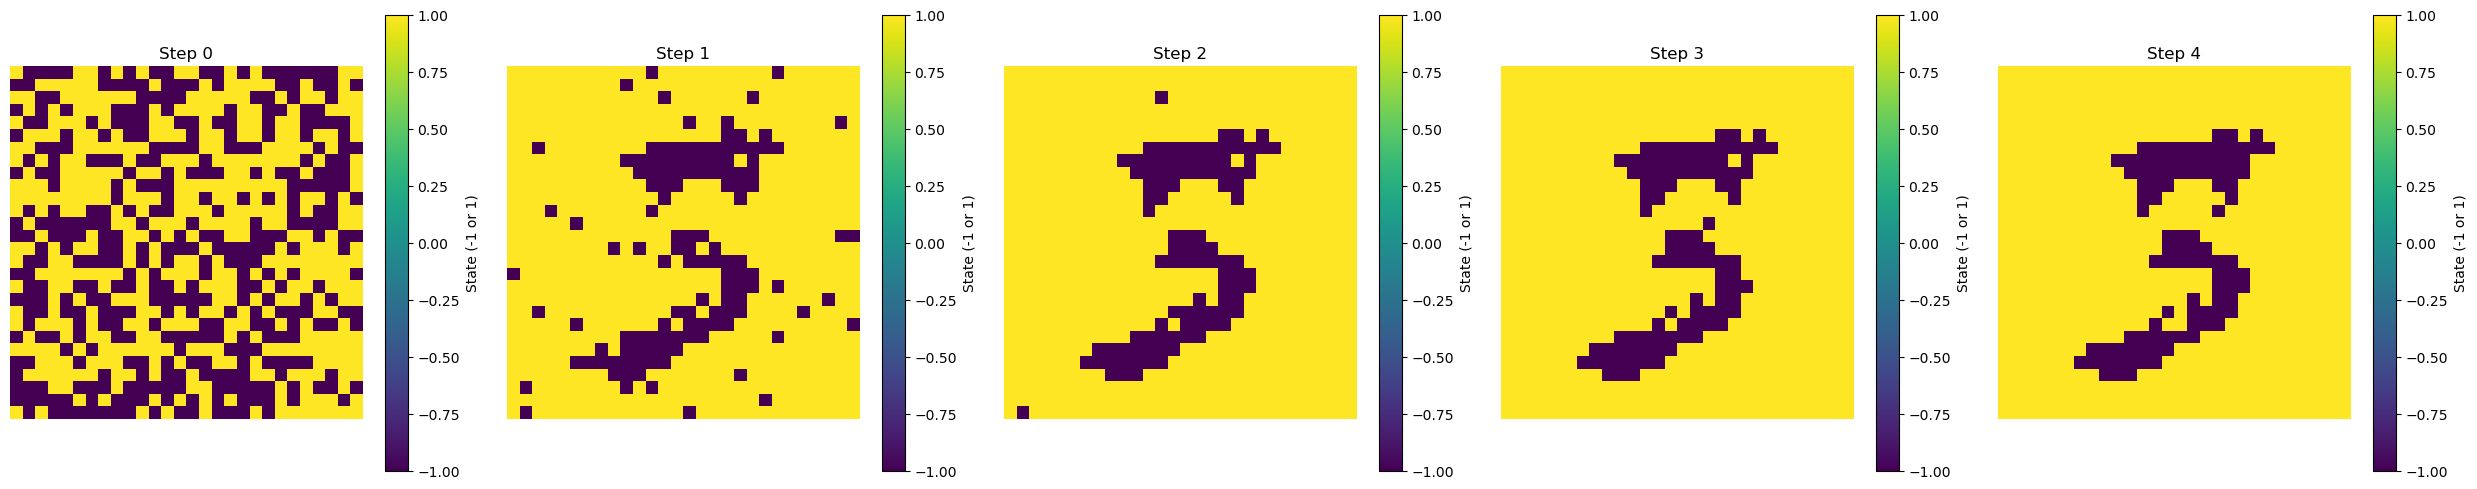

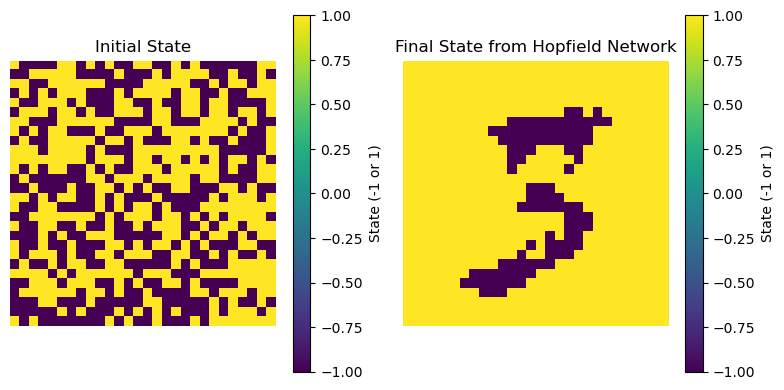

In [136]:
num_plots = samples.shape[0] 
Nsteps = 1
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
for i, step in enumerate(range(0, len(samples), Nsteps)):
    axes[i].imshow(samples[step].reshape((img_size, img_size)))
    axes[i].set_title(f"Step {step}")
    axes[i].axis("off")
    fig.colorbar(axes[i].imshow(samples[step].reshape((img_size, img_size))), ax=axes[i], label="State (-1 or 1)")

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(4 *2, 4))
# Visualizing initial state
img_size = int(np.sqrt(W.shape[0]))  # square image
axes[0].imshow(samples[0].reshape((img_size, img_size)))
axes[0].set_title(f"Initial State")
axes[0].axis("off")
fig.colorbar(axes[0].imshow(samples[0].reshape((img_size, img_size))), ax=axes[0], label="State (-1 or 1)")

# Visualizing last state
axes[1].imshow(samples[-1].reshape((img_size, img_size)))
axes[1].set_title(f"Final State from Hopfield Network")
axes[1].axis("off")
fig.colorbar(axes[1].imshow(samples[-1].reshape((img_size, img_size))), ax=axes[1], label="State (-1 or 1)")

plt.tight_layout()
plt.show()
